Link dos datasets

Samba: https://www.kaggle.com/datasets/clovesgtx/brazilian-music-samba-lyrics

Gospel: https://raw.githubusercontent.com/damarals/letras/master/inst/csv/letras.csv

Axe: https://www.kaggle.com/datasets/jorgefjr/brazilian-songs-lyrics

Funk: https://www.kaggle.com/datasets/sleshes/funk-carioca-dataset

Bossa Nova: https://www.kaggle.com/datasets/mcarujo/bossa-nova-lyrics

Rock,Sertanejo, Samba2 = https://github.com/gabriellmd/data-frames-nlp

In [2]:
import pandas as pd
import numpy as np
import string
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

In [3]:
bossa = pd.read_csv('datasets/bossa_nova_songs_dataset.csv')
samba = pd.read_csv('datasets/samba_dataset.csv',sep='|')
axe = pd.read_csv('datasets/letras_mus_br_axe.csv')
funk = pd.read_csv('datasets/Dataset_funk_carioca.csv')
gospel = pd.read_csv('datasets/gospel.csv') 

In [4]:
gospel_ajustado = pd.DataFrame(gospel['letra'])  #OK 55000
gospel_ajustado.rename(columns={'letra': 'lyric'}, inplace = True) #OK
gospel_ajustado.drop(gospel_ajustado.tail(51498).index,inplace = True) #3000
samba_ajustado = pd.DataFrame(samba['letra'])  #OK 3000
samba_ajustado.rename(columns={'letra': 'lyric'}, inplace = True) #OK
samba_ajustado.drop(samba_ajustado.tail(118).index,inplace = True) #3000
axe_ajustado = pd.DataFrame(axe['letras'])  #OK1000
axe_ajustado.rename(columns={'letras': 'lyric'}, inplace = True) #OK
funk_ajustado = pd.DataFrame(funk['letra'])  #OK 1000
funk_ajustado.rename(columns={'letra': 'lyric'}, inplace = True) #OK
bossa_ajustado = pd.DataFrame(bossa['song_lyrics'])  #OK 6000
bossa_ajustado.rename(columns={'song_lyrics': 'lyric'}, inplace = True) #OK
bossa_ajustado.drop(bossa_ajustado.tail(3106).index,inplace = True) #3000

In [5]:
bossa_ajustado['gen'] = 'Bossa Nova'
funk_ajustado['gen'] = 'Funk'
gospel_ajustado['gen'] = 'Gospel'
axe_ajustado['gen'] = 'Axe'
samba_ajustado['gen'] = 'Samba'

In [6]:
datasets = [bossa_ajustado,funk_ajustado,bossa_ajustado,axe_ajustado,samba_ajustado]

In [7]:
lyrics = pd.concat(datasets)
lyrics.reset_index(drop=True,inplace=True)
lyrics

,lyric,gen
0,"De tudo, ao meu amor serei atento antes E co...",Bossa Nova
1,Era uma casa Muito engraçada Não tinha teto ...,Bossa Nova
2,E por falar em saudade Onde anda você Onde a...,Bossa Nova
3,Filhos... Filhos? Melhor não tê-los! Mas se ...,Bossa Nova
4,É melhor ser alegre que ser triste Alegria é...,Bossa Nova
...,...,...
10995,( Não tenho lar Não tenho amor Pra que vou me ...,Samba
10996,o Senhor é a minha forçao meu escudo...minha ...,Samba
10997,Sorte é sorte o malandro também tem seu dia d...,Samba
10998,"A gente briga sem querer Chora ""prá"" voltar F...",Samba


In [8]:
def processamento_texto(txt):
    # remover quebras de linha
    txt = txt.replace('\n',' ')
    # remover símbolos de pontuação, resultando em um array de caracteres
    txt = [char for char in txt if char not in string.punctuation]
    # depois, juntar os caracteres em palavras novamente e separá-los em uma lista de tokens
    txt = ''.join(txt).split()
    # por fim, remover as stopwords da lista
    #txt = [word for word in txt if word.lower() not in stopwords.words('portuguese')]
    
    return txt

In [9]:
alg ={'SVM':{
    'fit_time':np.array([]),
    'score_time':np.array([]),
    'test_accuracy':np.array([]),
    'test_f1_score':np.array([]),
},
     'RF':{
    'fit_time':np.array([]),
    'score_time':np.array([]),
    'test_accuracy':np.array([]),
    'test_f1_score':np.array([]),
},
     'NB':{
    'fit_time':np.array([]),
    'score_time':np.array([]),
    'test_accuracy':np.array([]),
    'test_f1_score':np.array([]),
} }

In [10]:
for count in range(5):
    #aleatorio
    lyric_train,lyric_test,gen_train,gen_test = train_test_split(lyrics['lyric'],lyrics['gen'],test_size=0.3)
    #dados SVC
    pipeline_svc = Pipeline([
    ('bow',CountVectorizer(analyzer=processamento_texto,encoding ='unicode')),
    ('tfidf',TfidfTransformer()),
    ('svc',SVC())
    ])
    #dados NB
    pipeline_nb = Pipeline([
    ('bow',CountVectorizer(analyzer=processamento_texto,encoding ='unicode')),
    ('tfidf',TfidfTransformer()),
    ('nb',MultinomialNB())
    ])
    #dadps RF
    pipeline_rf = Pipeline([
    ('bow',CountVectorizer(analyzer=processamento_texto,encoding ='unicode')),
    ('tfidf',TfidfTransformer()),
    ('rf',RandomForestClassifier())
    ])
    
    #Etapa de Fit
    pipeline_svc.fit(lyric_train.values.astype('U'),gen_train.values.astype('U'))
    pipeline_nb.fit(lyric_train.values.astype('U'),gen_train.values.astype('U'))
    pipeline_rf.fit(lyric_train.values.astype('U'),gen_train.values.astype('U'))
    
    #Etapa 10-fold cross validation
    scoring = {'accuracy' : 'accuracy', 'f1_score' : 'f1_micro'}
    scores_svc = cross_validate(pipeline_svc,lyrics['lyric'].values.astype('U'),lyrics['gen'].values.astype('U'),cv=10,scoring=scoring)
    scores_nb = cross_validate(pipeline_nb,lyrics['lyric'].values.astype('U'),lyrics['gen'].values.astype('U'),cv=10,scoring=scoring)
    scores_rf = cross_validate(pipeline_rf,lyrics['lyric'].values.astype('U'),lyrics['gen'].values.astype('U'),cv=10,scoring=scoring)
    
    #Aninhamento de médias
    #SVM
    alg['SVM']['fit_time'] = np.append(alg['SVM']['fit_time'], scores_svc['fit_time'].mean())
    alg['SVM']['score_time'] = np.append(alg['SVM']['score_time'], scores_svc['score_time'].mean())
    alg['SVM']['test_accuracy'] = np.append(alg['SVM']['test_accuracy'], scores_svc['test_accuracy'].mean())
    alg['SVM']['test_f1_score'] = np.append(alg['SVM']['test_f1_score'], scores_svc['test_f1_score'].mean())
    #NB
    alg['NB']['fit_time'] = np.append(alg['NB']['fit_time'], scores_nb['fit_time'].mean())
    alg['NB']['score_time'] = np.append(alg['NB']['score_time'], scores_nb['score_time'].mean())
    alg['NB']['test_accuracy'] = np.append(alg['NB']['test_accuracy'], scores_nb['test_accuracy'].mean())
    alg['NB']['test_f1_score'] = np.append(alg['NB']['test_f1_score'], scores_nb['test_f1_score'].mean())
    #RF
    alg['RF']['fit_time'] = np.append(alg['RF']['fit_time'], scores_rf['fit_time'].mean())
    alg['RF']['score_time'] = np.append(alg['RF']['score_time'], scores_rf['score_time'].mean())
    alg['RF']['test_accuracy'] = np.append(alg['RF']['test_accuracy'], scores_rf['test_accuracy'].mean())
    alg['RF']['test_f1_score'] = np.append(alg['RF']['test_f1_score'], scores_rf['test_f1_score'].mean())
    

In [11]:
alg

{'SVM': {'fit_time': array([207.34197218,  87.36426384,  96.24261546,  93.44627266,
          85.22867527]),
  'score_time': array([15.82149842,  6.84751348,  7.54293625,  7.36248982,  6.67282929]),
  'test_accuracy': array([0.82127273, 0.82127273, 0.82127273, 0.82127273, 0.82127273]),
  'test_f1_score': array([0.82127273, 0.82127273, 0.82127273, 0.82127273, 0.82127273])},
 'RF': {'fit_time': array([85.25479734, 69.22626827, 77.2579206 , 66.60238929, 65.90213981]),
  'score_time': array([0.29199908, 0.2286329 , 0.26484087, 0.22070985, 0.22501905]),
  'test_accuracy': array([0.76054545, 0.76063636, 0.76      , 0.76254545, 0.75863636]),
  'test_f1_score': array([0.76054545, 0.76063636, 0.76      , 0.76254545, 0.75863636])},
 'NB': {'fit_time': array([2.00988569, 1.64678171, 1.83403141, 1.85574608, 1.57498763]),
  'score_time': array([0.19064798, 0.15430329, 0.18295522, 0.18057325, 0.14743645]),
  'test_accuracy': array([0.58527273, 0.58527273, 0.58527273, 0.58527273, 0.58527273]),
  'tes

In [12]:
alg_media_final ={'SVM':{
    'fit_time': alg['SVM']['fit_time'].mean(),
    'score_time':alg['SVM']['score_time'].mean(),
    'test_accuracy':alg['SVM']['test_accuracy'].mean(),
    'test_f1_score':alg['SVM']['test_f1_score'].mean(),
},
     'RF':{
    'fit_time': alg['RF']['fit_time'].mean(),
    'score_time':alg['RF']['score_time'].mean(),
    'test_accuracy':alg['RF']['test_accuracy'].mean(),
    'test_f1_score':alg['RF']['test_f1_score'].mean(),
},
     'NB':{
    'fit_time': alg['NB']['fit_time'].mean(),
    'score_time':alg['NB']['score_time'].mean(),
    'test_accuracy':alg['NB']['test_accuracy'].mean(),
    'test_f1_score':alg['NB']['test_f1_score'].mean(),
} }

In [13]:
alg_media_final['SVM']['execution_time'] = alg_media_final['SVM']['fit_time'] + alg_media_final['SVM']['score_time']
alg_media_final['RF']['execution_time'] = alg_media_final['RF']['fit_time'] + alg_media_final['RF']['score_time']
alg_media_final['NB']['execution_time'] = alg_media_final['NB']['fit_time'] + alg_media_final['NB']['score_time']

In [14]:
alg_media_final

{'SVM': {'fit_time': 113.92475988388063,
  'score_time': 8.849453454017638,
  'test_accuracy': 0.8212727272727273,
  'test_f1_score': 0.8212727272727273,
  'execution_time': 122.77421333789826},
 'RF': {'fit_time': 72.84870306015014,
  'score_time': 0.24624034881591794,
  'test_accuracy': 0.7604727272727274,
  'test_f1_score': 0.7604727272727273,
  'execution_time': 73.09494340896606},
 'NB': {'fit_time': 1.7842865037918092,
  'score_time': 0.17118323802948,
  'test_accuracy': 0.5852727272727273,
  'test_f1_score': 0.5852727272727273,
  'execution_time': 1.9554697418212892}}

In [16]:
import matplotlib.pyplot as plt

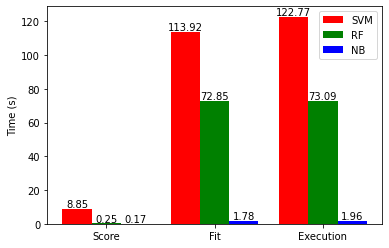

In [17]:
N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.27      # the width of the bars

fig = plt.figure()
ax = fig.add_subplot()

yvals = [alg_media_final['SVM']['score_time'], alg_media_final['SVM']['fit_time'], alg_media_final['SVM']['execution_time']]
rects1 = ax.bar(ind, yvals, width, color='r')
zvals = [alg_media_final['RF']['score_time'], alg_media_final['RF']['fit_time'], alg_media_final['RF']['execution_time']]
rects2 = ax.bar(ind+width, zvals, width, color='g')
kvals = [alg_media_final['NB']['score_time'], alg_media_final['NB']['fit_time'], alg_media_final['NB']['execution_time']]
rects3 = ax.bar(ind+width*2, kvals, width, color='b')

ax.set_ylabel('Time (s)')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('Score', 'Fit', 'Execution') )
ax.legend( (rects1[0], rects2[0], rects3[0]), ('SVM', 'RF', 'NB') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., h+1, '%.2f'%h,
                ha='center')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

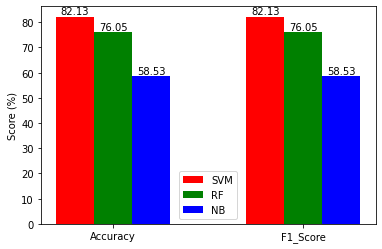

In [18]:
N = 2
ind = np.arange(N)  # the x locations for the groups
width = 0.20      # the width of the bars

fig = plt.figure()
ax = fig.add_subplot()

yvals = [alg_media_final['SVM']['test_accuracy']*100, alg_media_final['SVM']['test_f1_score']*100]
rects1 = ax.bar(ind, yvals, width, color='r')
zvals = [alg_media_final['RF']['test_accuracy']*100, alg_media_final['RF']['test_f1_score']*100]
rects2 = ax.bar(ind+width, zvals, width, color='g')
kvals = [alg_media_final['NB']['test_accuracy']*100, alg_media_final['NB']['test_f1_score']*100]
rects3 = ax.bar(ind+width*2, kvals, width, color='b')

ax.set_ylabel('Score (%)')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('Accuracy', 'F1_Score') )
ax.legend( (rects1[0], rects2[0], rects3[0]), ('SVM', 'RF', 'NB') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., h+1, '%.2f'%h,
                ha='center')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()